In [62]:
import bokeh.plotting as bpl
import logging
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys
import os
from glob import glob
import h5py    
try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

import pickle
from caiman.base.rois import register_multisession
from caiman.base.rois import register_ROIs
from caiman.utils import visualization
from caiman.utils.utils import download_demo
import caiman as cm
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params



from matplotlib import pyplot as plt
import numpy as np
import imageio
from caiman_analysis import load_as_obj



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
list_of_dates = ('20200802','20200731')
list_of_expnames = ('ori','ori2') 
#alternative: use a list of out_paths 

In [64]:
list(list_of_dates)

['20200802', '20200731']

In [65]:
user_name = 'Mora'
#is your FOV cropped? if yes, please enter 
x_start = 100 # if not cropped this is 0
x_end = 450 # if not cropped this is 512
mouse = 'MBOT5_419'
#we'll create a list of CNMF output files
cnms = list(list_of_dates)
image_path = list(list_of_dates)
listoftifFolders =  list(list_of_dates)

for i, date in enumerate(list_of_dates):
    
    exp_name = list_of_expnames[i]
    tif_folder = 'D://'+ user_name + '//' + date +'//' + mouse + '//' + exp_name + '//'
    listoftifFolders[i]=tif_folder
    out_path = tif_folder + '//' + 'out//'
    reference_folder ='D://' + user_name +'//'+ date +'//'+ mouse +'//'+ 'reference' + '//'
    image_path[i] = glob(reference_folder + '*caiman_template.png')[0]

    #out_path = list_of_out_paths[i] #if you just have a list with the output paths where the hdf5 objects are, comment the 3 previous lines and use this one
    hs = glob(out_path + '*.hdf5')[-1]
    cnms[i] = load_as_obj(hs)


In [66]:
template = list(list_of_dates)
for i in np.arange(len(list_of_dates)):
    template[i] = imageio.imread(image_path[i])


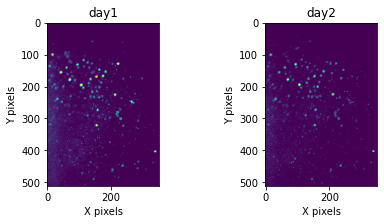

In [67]:
ncol=len(list_of_dates)
fig, axes = plt.subplots(1,ncol, figsize=(3*ncol,1.5*ncol), constrained_layout=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.set_title('day'+str(i+1))
    ax.set_ylabel('Y pixels')
    ax.set_xlabel('X pixels')
    ax.imshow(template[i])

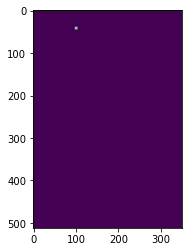

In [68]:
#verify that the estimates.A is fine and has the right shape by plotting one cell
dims = template[0].shape
plt.figure()
plt.imshow(np.reshape(cnms[0].estimates.A[:,0].toarray(), dims, order='F'))

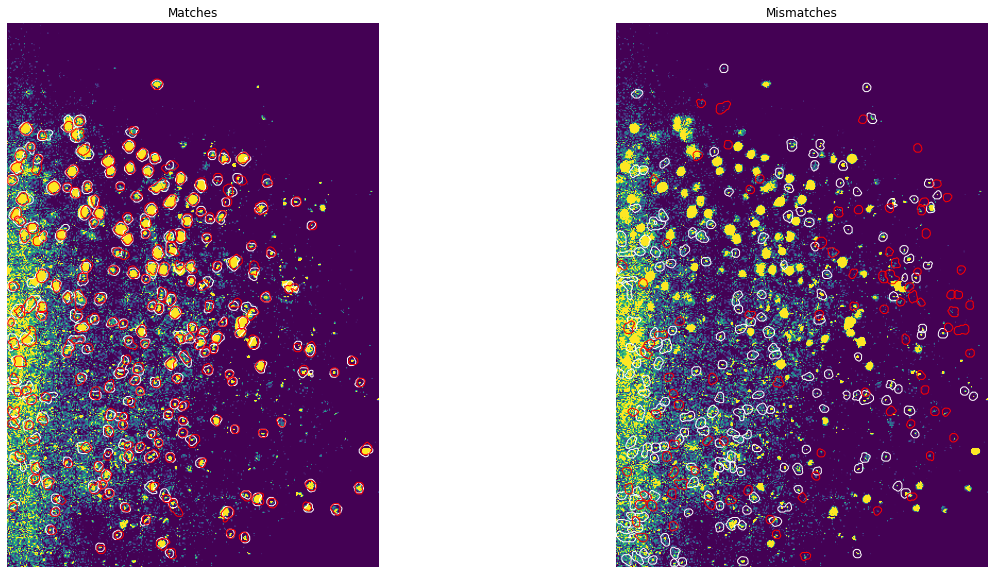

In [69]:
#first, test it with only 2 sessions
multisessionROIs = register_ROIs(cnms[0].estimates.A, cnms[1].estimates.A, dims, template1=template[0], template2=template[1], align_flag=False, D=None, max_thr=0, use_opt_flow=True, thresh_cost=0.7, max_dist=10, enclosed_thr=None, print_assignment=False, plot_results=True, Cn=None, cmap='viridis')

<font size="5">Now, let's apply the algorithm to multiple sessions </font>

The function returns 3 variables for further analysis:

spatial_union: csc_matrix (# pixels X # total distinct components), the union of all ROIs across all sessions aligned to the FOV of the last session.
assignments: ndarray (# total distinct components X # sessions). assignments[i,j]=k means that component k from session j has been identified as component i from the union of all components, otherwise it takes a NaN value. Note that for each i there is at least one session index j where assignments[i,j]!=NaN.
matchings: list of (# sessions) lists. Saves spatial_union indices of individual components in each session. matchings[j][k] = i means that component k from session j is represented by component i in the union of all components spatial_union. In other words assignments[matchings[j][k], j] = j.

Use register_multisession()
The function register_multisession() requires 3 arguments:

A: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
dims: Dimensions of the FOV, needed to restore spatial components to a 2D image
templates: List of ndarray matrices of size dims, template image of each session

In [70]:
A= [cnms[0].estimates.A,cnms[1].estimates.A] # this can be a list as long as 
dims = dims
templates = [template[0],template[1]]
spatial_union, assignments, matchings = register_multisession(A=A, dims=dims, templates=templates,align_flag=True)

# to solve: either there's a bug or the having the same template doesn't work for some reason
# maybe it's this:
# # Division-assignment operator raises error, separate division and assignment work #10565
# https://github.com/numpy/numpy/issues/10565

C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [71]:
out_path

'D://Mora//20200731//MBOT5_419//ori2////out//'

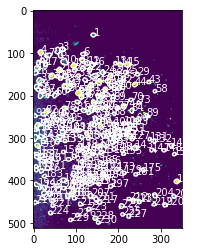

In [72]:

# Filter components by number of sessions the component could be found
n_reg = 2  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);

# Use filtered indices to select the corresponding spatial components
spatial_filtered = cnms[0].estimates.A[:, assignments_filtered[:, 0]]

# Plot spatial components of the selected components on the template of the last session
visualization.plot_contours(spatial_filtered, templates[-1]);
plt.savefig(out_path + 'components of day 2 in template of day 1')

In [73]:
shape = [cnms[0].estimates.A,cnms[1].estimates.A]
cnm_list = [cnms[0],cnms[1]]

## Combining data of components over multiple sessions

Now that all sessions are aligned and we have a list of re-registered neurons, we can use `assignments` and `matchings` to collect traces from neurons over different sessions.

As an exercise, we can collect the traces of all neurons that were registered in all sessions. We already gathered the indices of these neurons in the previous cell in `assignments_filtered`. Assuming that traces of each session are saved in their own `CNMF` object collected in a list, we can iterate through `assignments_filtered` and use these indices to find the re-registered neurons in every session.

Note: This notebook does not include the traces of the extracted neurons, only their spatial components. As such the loop below will produce an error. However, it demonstrates how to use the results of the registration to in your own analysis to extract the traces of the same neurons across different sessions.

In [74]:
traces = np.zeros(assignments_filtered.shape, dtype=np.ndarray)
for i in range(traces.shape[0]):
    for j in range(traces.shape[1]):
        traces[i,j] = cnm_list[j].estimates.C[int(assignments_filtered[i,j])]

In [75]:
#recover the original traces for each session for all the overlapping neurons
cells =len(traces)
frames = len(traces[0,0])
traces_0 = np.zeros((cells,frames))                 
traces_1 = np.zeros((cells,frames))

for i in np.arange(cells):
    traces_0[i,:] = traces[i,0]
    traces_1[i,:] = traces[i,1]

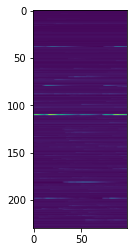

In [76]:
plt.imshow(traces_0[:,1:100])

In [77]:
listoftifFolders[1]

'D://Mora//20200731//MBOT5_419//ori2//'

In [78]:
from caiman_analysis import *
from vis import *
# get file sizes of the tifs for the first session
session = 0

get_file_sizes = True
if get_file_sizes:
    files_sizes = cm.source_extraction.cnmf.utilities.get_file_size(glob(listoftifFolders[session]+'*.tif'))
    
splits= ((np.asarray(files_sizes[1]))/2).astype(int)
#alternative, build your splits with the trialLen and the numTrials
#splits=(np.ones(numTrials)*trialLen).astype(int) 
traces_s0 = process_data(traces_0, splits,normalizer='scale')

In [79]:
# get file sizes of the tifs for the first session
session = 1

get_file_sizes = True
if get_file_sizes:
    files_sizes = cm.source_extraction.cnmf.utilities.get_file_size(glob(listoftifFolders[session]+'*.tif'))
    

splits= ((np.asarray(files_sizes[1]))/2).astype(int)
#alternative, build your splits with the trialLen and the numTrials
#splits=(np.ones(numTrials)*trialLen).astype(int) 
traces_s1 = process_data(traces_1, splits,normalizer='scale')

In [80]:
traces_s1.shape

(240, 230, 75)

In [81]:
import scipy.io as sio
from vis import create_df
import h5py

daq_path1 = 'Z://frankenshare//Mora//visStim_Data//20200802//ori_MBOT5_419_20200802.mat'
daq_path1 = glob(daq_path1)[0]
mat1 = h5py.File(daq_path1)

daq_path2 = 'Z://frankenshare//Mora//visStim_Data//20200731//ori_MBOT5_419_20200731.mat'
daq_path2 = glob(daq_path2)[0]
mat2 = h5py.File(daq_path2)

C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\ipykernel_launcher.py:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # This is added back by InteractiveShellApp.init_path()


In [82]:
#for ORIENTATION SELECTIVITY EXPERIMENTS
vis_id = tuple(np.squeeze(np.array(mat1['stimConds'][:,2].astype('int'))))
vis_oris =  tuple(np.squeeze(np.array(mat1['shuffleStims'][:].astype('int'))))

vis_oris_n = np.array(vis_oris)
for i, ori in enumerate(vis_id):
    vis_oris_n[vis_oris_n==(i+1)]=vis_id[i]
    vis_oris1 =tuple(vis_oris_n)

fr = 15

In [83]:
#for ORIENTATION SELECTIVITY EXPERIMENTS
vis_id = tuple(np.squeeze(np.array(mat2['stimConds'][:,2].astype('int'))))
vis_oris =  tuple(np.squeeze(np.array(mat2['shuffleStims'][:].astype('int'))))

vis_oris_n = np.array(vis_oris)
for i, ori in enumerate(vis_id):
    vis_oris_n[vis_oris_n==(i+1)]=vis_id[i]
    vis_oris2 =tuple(vis_oris_n)

In [84]:
%matplotlib inline
vis_df1 = create_df(traces_s0, vis_stim=vis_oris1, vis_name='ori', fr=fr)
vis_df2 = create_df(traces_s1, vis_stim=vis_oris2, vis_name='ori', fr=fr)
win= (1.5,2,2.1,5) 
col_name = 'ori'
df1, mean_df1 = run_pipeline(vis_df1, win, col_name)
df2, mean_df2 = run_pipeline(vis_df2, win, col_name)


There are 37 visually responsive cells, out of 230 (16.09%)
There are 45 visually responsive cells, out of 230 (19.57%)


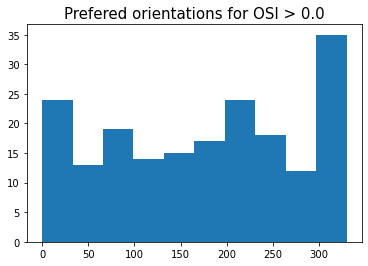

In [85]:
osi_filter = 0.0
df = mean_df1
pref_oris_selective = df[df.osi>osi_filter].set_index('pdir').groupby(['cell'])['df'].idxmax() # get the max/pref ori
plt.hist(pref_oris_selective)
plt.title('Prefered orientations for OSI > '+str(osi_filter), fontsize = 15)
plt.savefig(out_path + 'pref oris histogram')
plt.show()

In [86]:
mean_df1

,cell,ori,trial,df,vis_resp,pval,pref,ortho,pdir,osi
0,0,0,2,-3.074168e+00,False,0.611766,30,120,0,0.004667
1,0,0,20,-5.551115e-17,False,0.611766,30,120,0,0.004667
2,0,0,33,-5.551115e-17,False,0.611766,30,120,0,0.004667
3,0,0,46,-1.717758e-01,False,0.611766,30,120,0,0.004667
4,0,0,48,-6.462204e-07,False,0.611766,30,120,0,0.004667
...,...,...,...,...,...,...,...,...,...,...
55195,229,330,187,9.602656e-01,False,0.587281,150,60,150,0.001879
55196,229,330,196,2.220446e-16,False,0.587281,150,60,150,0.001879
55197,229,330,215,-2.556375e-02,False,0.587281,150,60,150,0.001879
55198,229,330,225,2.220446e-16,False,0.587281,150,60,150,0.001879


In [87]:
mean_df2

,cell,ori,trial,df,vis_resp,pval,pref,ortho,pdir,osi
0,0,0,3,-3.913900e-04,False,0.842418,0,90,0,0.011672
1,0,0,19,-2.131996e-04,False,0.842418,0,90,0,0.011672
2,0,0,26,2.831826e-01,False,0.842418,0,90,0,0.011672
3,0,0,42,-1.276942e-01,False,0.842418,0,90,0,0.011672
4,0,0,52,-8.615290e-01,False,0.842418,0,90,0,0.011672
...,...,...,...,...,...,...,...,...,...,...
55195,229,330,186,-1.986275e-01,False,0.552786,120,30,120,0.006801
55196,229,330,195,2.220446e-16,False,0.552786,120,30,120,0.006801
55197,229,330,205,-6.620455e-01,False,0.552786,120,30,120,0.006801
55198,229,330,225,-5.529494e-01,False,0.552786,120,30,120,0.006801


In [88]:
np.arange(50,60)

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

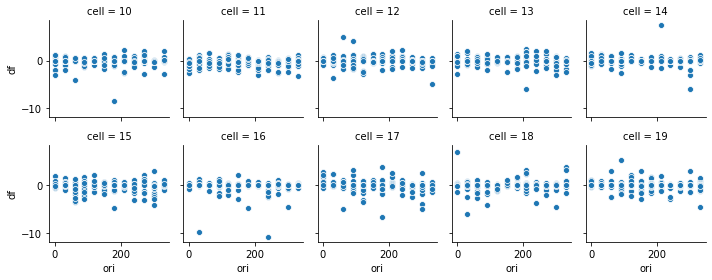

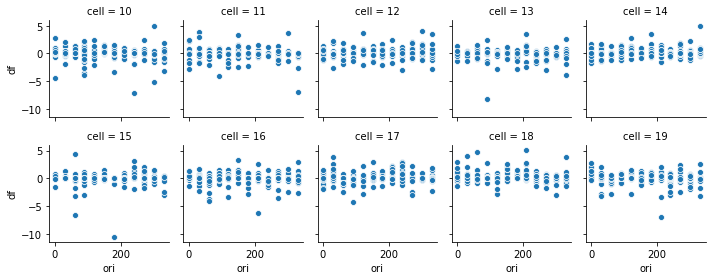

In [115]:
import seaborn as sns
cells = list(np.arange(10,20))
mdf = mean_df1
sns.relplot(x='ori', y='df', data=mdf[mdf.cell.isin(cells)], col='cell', col_wrap=5, height= 2,aspect = 1)
mdf = mean_df2
sns.relplot(x='ori', y='df', data=mdf[mdf.cell.isin(cells)], col='cell', col_wrap=5, height= 2,aspect = 1)
#plt.savefig(out_path +'more tuning curves')
plt.show()

In [90]:
#find cells with same ori preference across sessions:

intersection = list(vis_id)

for i,isOri in enumerate(vis_id):
    a = mean_df1[(mean_df1.pdir == isOri)].cell.unique() # if you want to filter by OSI, add (mean_df.osi>0.)
    b = mean_df2[(mean_df2.pdir == isOri)].cell.unique()
    intersection[i] = set(a) & set(b)

In [92]:
intersection

[{0},
 set(),
 {132},
 {101, 129, 198},
 {207},
 {16, 183},
 {179, 224},
 {13, 115, 121, 149, 192},
 {162, 201},
 {175, 226},
 {32, 51, 169},
 {86, 91, 117}]

In [105]:
list(intersection[9])

[192, 13, 115, 149, 121]

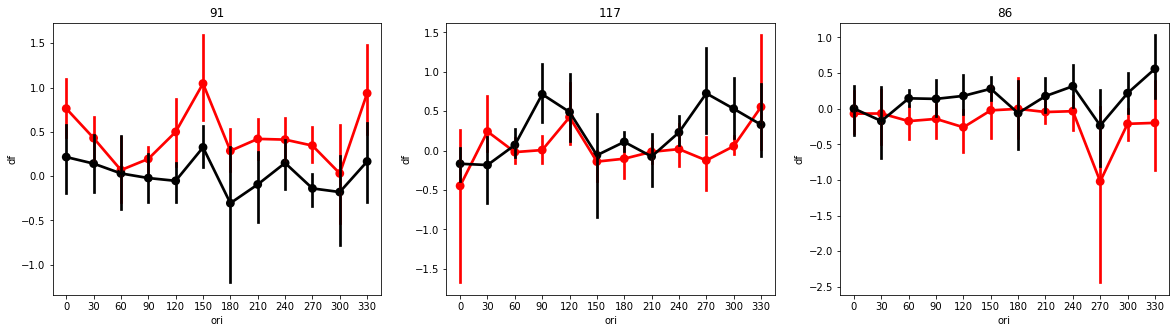

In [109]:
# get examples of good osis
cells =list(intersection[11])
how_many =len(cells)
fig, axes = plt.subplots(ncols=how_many, nrows=1,figsize=(20, 5))


for i, ax in zip(range(how_many), axes.flat):
    df2plt = mean_df1 
    sns.pointplot(x='ori', y='df', data=df2plt[df2plt.cell==(cells[i])], kind='point', ax=ax,color='red')
    df2plt = mean_df2
    sns.pointplot(x='ori', y='df', data=df2plt[df2plt.cell==(cells[i])], kind='point', ax=ax,color='black')
    ax.set_title(str(cells[i]))

#plt.savefig(out_path + 'tuning curves')
plt.show()

In [94]:
intersection

[{0},
 set(),
 {132},
 {101, 129, 198},
 {207},
 {16, 183},
 {179, 224},
 {13, 115, 121, 149, 192},
 {162, 201},
 {175, 226},
 {32, 51, 169},
 {86, 91, 117}]

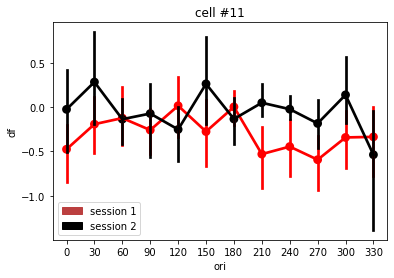

In [117]:
#get a pretty cell and plot with legend
import seaborn as sns
cells = [11]
mdf = mean_df1
a= sns.pointplot(x='ori', y='df', data=mdf[mdf.cell.isin(cells)], col='cell', col_wrap=5, height= 2,aspect = 1,color='red')
mdf = mean_df2
a= sns.pointplot(x='ori', y='df', data=mdf[mdf.cell.isin(cells)], col='cell', col_wrap=4, height= 2,aspect = 1,color='black')
a.set_title('cell #'+ str(cells[0]))
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='#bb3f3f', label='session 1')
black_patch = mpatches.Patch(color='#000000', label='session 2')
plt.legend(handles=[red_patch, black_patch])
plt.show()